# Compare sea surface height model output (at three resolutions) and observations

This notebook is an example of how to:

- load sea-surface height from two different resolution runs
- plot the time-mean and standard deviation of sea-surface height (ssh)
- compare model output to observations (AVISO dataset)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import matplotlib.pyplot as plt
import cosima_cookbook as cc
import numpy as np

import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cft
from dask.distributed import Client
import cmocean as cm

In [2]:
client = Client(n_workers=4)
client

Client Scheduler: tcp://127.0.0.1:32773 Dashboard: /proxy/8787/status,Cluster Workers: 4 Cores: 48 Memory: 202.49 GB


## Start a Cosima cookbook database session

In [3]:
session = cc.database.create_session()

In [4]:
#SSH variable in ACCESS-OM2 models
variable = 'sea_level'

# dates to match the AVISO record
start_time = '1993-01-16'
end_time = '2010-12-16'

## Load SSH for a 1$^{\circ}$ run

Here we can specify the rough start and end times using the "start_time" and "end_time" arguments. But, this yields a dataset that has an extra 12 months on either end, so we slice the data to match the AVISO dataset below.

In [5]:
expt = '1deg_jra55v13_iaf_spinup1_B1'  # 1-deg experiment
ssh1 = cc.querying.getvar(expt, variable, session, start_time=start_time, end_time=end_time)
ssh1 = ssh1.sel(time=slice(start_time, end_time)) # slice to the same time range as AVISO
ssh1

,Array,Chunk
Bytes,93.31 MB,432.00 kB
Shape,"(216, 300, 360)","(1, 300, 360)"
Count,700 Tasks,216 Chunks
Type,float32,numpy.ndarray


## Load SSH for a 0.25$^{\circ}$ run

In [6]:
expt = '025deg_jra55v13_ryf8485_gmredi6'  # 0.25-deg experiment
ssh025 = cc.querying.getvar(expt, variable, session, start_time=start_time, end_time=end_time)
ssh025 = ssh025.sel(time=slice(start_time, end_time)) # slice to the same time range as AVISO
ssh025

,Array,Chunk
Bytes,1.34 GB,1.56 MB
Shape,"(216, 1080, 1440)","(1, 540, 720)"
Count,2794 Tasks,864 Chunks
Type,float32,numpy.ndarray


# Load AVISO observational data

Use xarray to load 'zos': the sea surface height variable name. Here we slice off the first three time points so that the data starts in January and spans an even 18 years.

In [7]:
obs = xr.open_dataset('/g/data/hh5/tmp/cosima/observations/original/zos_AVISO_L4_199210-201012.nc')   # AVISO dataset
obs_ssh = obs.zos.sel(time=slice(start_time, end_time))
obs_ssh

<xarray.DataArray 'zos' (time: 216, lat: 180, lon: 360)>
[13996800 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1993-01-16T12:00:00 ... 2010-12-16T12:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Attributes:
    standard_name:     sea_surface_height_above_geoid
    long_name:         Sea Surface Height Above Geoid
    units:             m
    original_name:     maps_of_absolute_dynamic_topography
    history:           2011-02-11, 12:02:38, AVISO, Aviso2Cmor 2009-01-01 200...
    original_units:    cm
    cell_methods:      time: mean
    cell_measures:     area: areacello
    associated_files:  baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation...

# Make comparison plot

Use cartopy to plot the time-mean and standard deviation of both of the model outputs and the AVISO data (obs).

/g/data3/hh5/public/apps/miniconda3/envs/analysis3-20.01/lib/python3.7/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


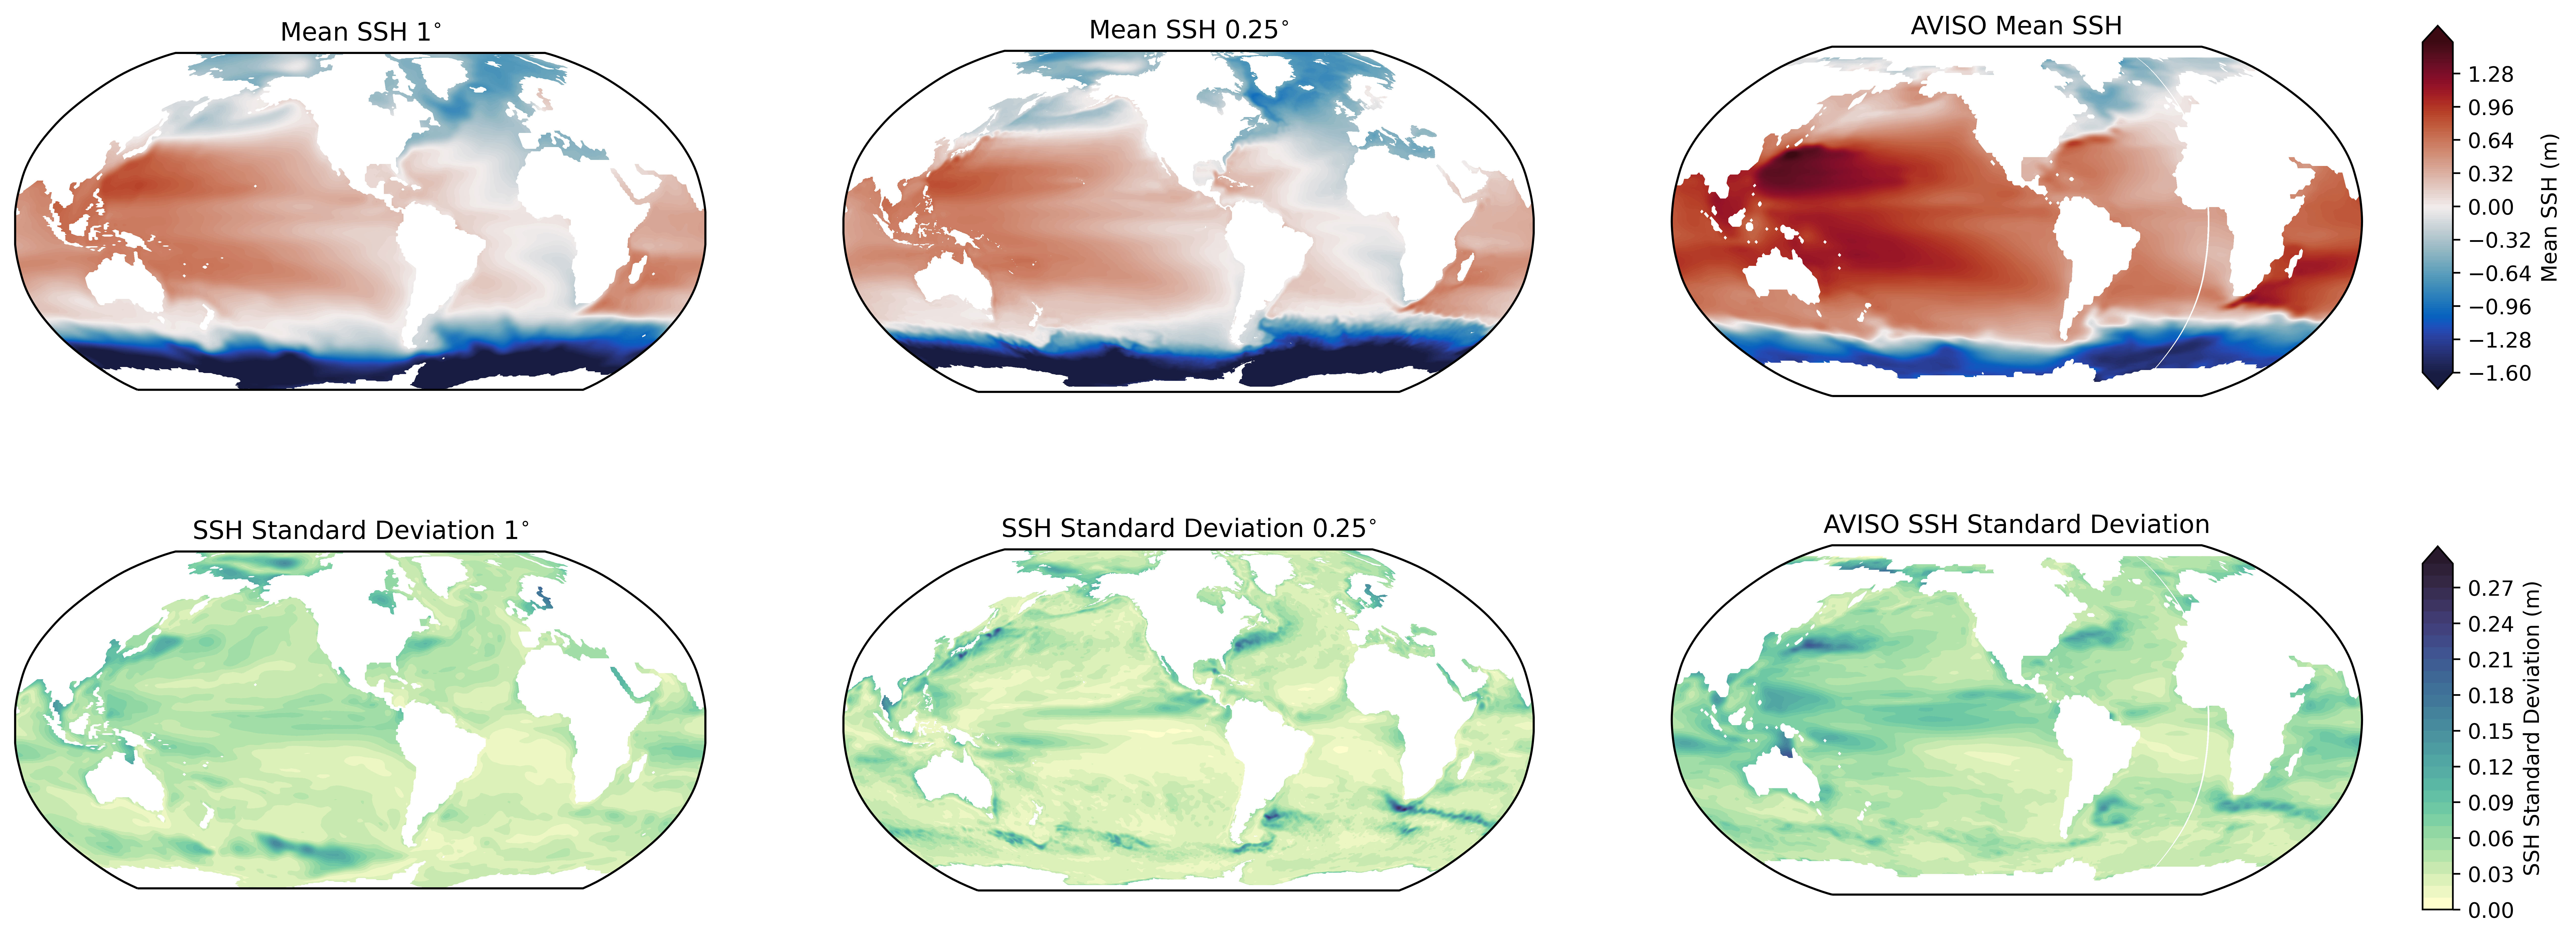

In [8]:
plt.figure(figsize=(20,8), dpi=300)

# Define the contour levels and spacing 
mlev = np.arange(-1.6, 1.6, 0.02)  # levels for mean ssh
slev = np.arange( 0.0, 0.3, 0.01)  # levels for std ssh
    

# mean SSH plots

ax = plt.subplot(2, 3, 1, projection=ccrs.Robinson(central_longitude=-100))
p1 = ssh1.mean(dim='time').plot.contourf(cmap=cm.cm.balance, levels=mlev, add_colorbar=False,
                                         extend='both', transform=ccrs.PlateCarree())
ax.set_title('Mean SSH 1$^{\circ}$')

ax = plt.subplot(2, 3, 2, projection=ccrs.Robinson(central_longitude=-100))
p1 = ssh025.mean(dim='time').plot.contourf(cmap=cm.cm.balance, levels=mlev, add_colorbar=False,
                                          extend='both', transform=ccrs.PlateCarree())
ax.set_title('Mean SSH 0.25$^{\circ}$')


ax = plt.subplot(2, 3, 3, projection=ccrs.Robinson(central_longitude=-100))
p1 = obs_ssh.mean(dim='time').plot.contourf(cmap=cm.cm.balance, levels=mlev, add_colorbar=False,
                                            extend='both', transform=ccrs.PlateCarree())
ax.set_title('AVISO Mean SSH')


# std SSH plots
ax2 = plt.subplot(2, 3, 4, projection=ccrs.Robinson(central_longitude=-100))
p2 = ssh1.std(dim='time').plot.contourf(cmap=cm.cm.deep, levels=slev, add_colorbar=False,
                                        extend='max', transform=ccrs.PlateCarree())
ax2.set_title('SSH Standard Deviation 1$^{\circ}$')


ax2 = plt.subplot(2,3,5,projection=ccrs.Robinson(central_longitude=-100))
p2 = ssh025.std(dim='time').plot.contourf(cmap=cm.cm.deep, levels=slev, add_colorbar=False,
                                          extend='max', transform=ccrs.PlateCarree())
ax2.set_title('SSH Standard Deviation 0.25$^{\circ}$')


ax2 = plt.subplot(2,3,6,projection=ccrs.Robinson(central_longitude=-100))
p2 = obs_ssh.std(dim='time').plot.contourf(cmap=cm.cm.deep, levels=slev,add_colorbar=False,
                                           extend='max', transform=ccrs.PlateCarree())
ax2.set_title('AVISO SSH Standard Deviation')

# Colorbars
ax1 = plt.axes([0.92, 0.57, 0.01, 0.3])
cb = plt.colorbar(p1, cax=ax1, orientation='vertical')
cb.ax.set_ylabel('Mean SSH (m)')

ax2 = plt.axes([0.92, 0.14, 0.01, 0.3])
cb = plt.colorbar(p2, cax=ax2, orientation='vertical')
cb.ax.set_ylabel('SSH Standard Deviation (m)');